# GNN 추천 시스템 진단
# 데이터 + 모델 종합 분석

In [1]:
import os
import pickle
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("진단 노트북 시작!")
print(f"PyTorch: {torch.__version__}")
print(f"Device: {'mps' if torch.backends.mps.is_available() else 'cpu'}")

진단 노트북 시작!
PyTorch: 2.9.0
Device: mps


## 1. 데이터 로드

In [2]:
# 경로 설정
DATA_DIR = '../data'
PROCESSED_DIR = '../data/processed'
MODEL_DIR = '../models'

# ID mappings
with open(os.path.join(PROCESSED_DIR, 'id_mappings.pkl'), 'rb') as f:
    mappings = pickle.load(f)

n_users = len(mappings['user_id_map'])
n_items = len(mappings['item_id_map'])

# 원본 데이터
df_raw = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_raw['user_id'] = df_raw['user'].map(mappings['user_id_map'])
df_raw['item_id'] = df_raw['item'].map(mappings['item_id_map'])

# Split 데이터
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'train_split_v3.csv'))
valid_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'valid_split_v3.csv'))
test_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'test_split_v3.csv'))

print("=" * 60)
print("데이터 로드 완료")
print("=" * 60)
print(f"Users: {n_users}, Items: {n_items}")
print(f"\nRaw data: {len(df_raw):,}")
print(f"Train: {len(train_df):,}")
print(f"Valid: {len(valid_df):,}")
print(f"Test: {len(test_df):,}")

데이터 로드 완료
Users: 668, Items: 10321

Raw data: 105,139
Train: 44,542
Valid: 6,123
Test: 13,389


## 2. Split 품질 분석

2.1 User별 Item 수 분포 (Split별)


,Split,Mean,Median,Std,Min,Max
0,Train,66.679641,31.0,107.985905,1,1190
1,Valid,9.537383,4.0,15.629366,1,170
2,Test,20.043413,10.0,30.862313,1,341


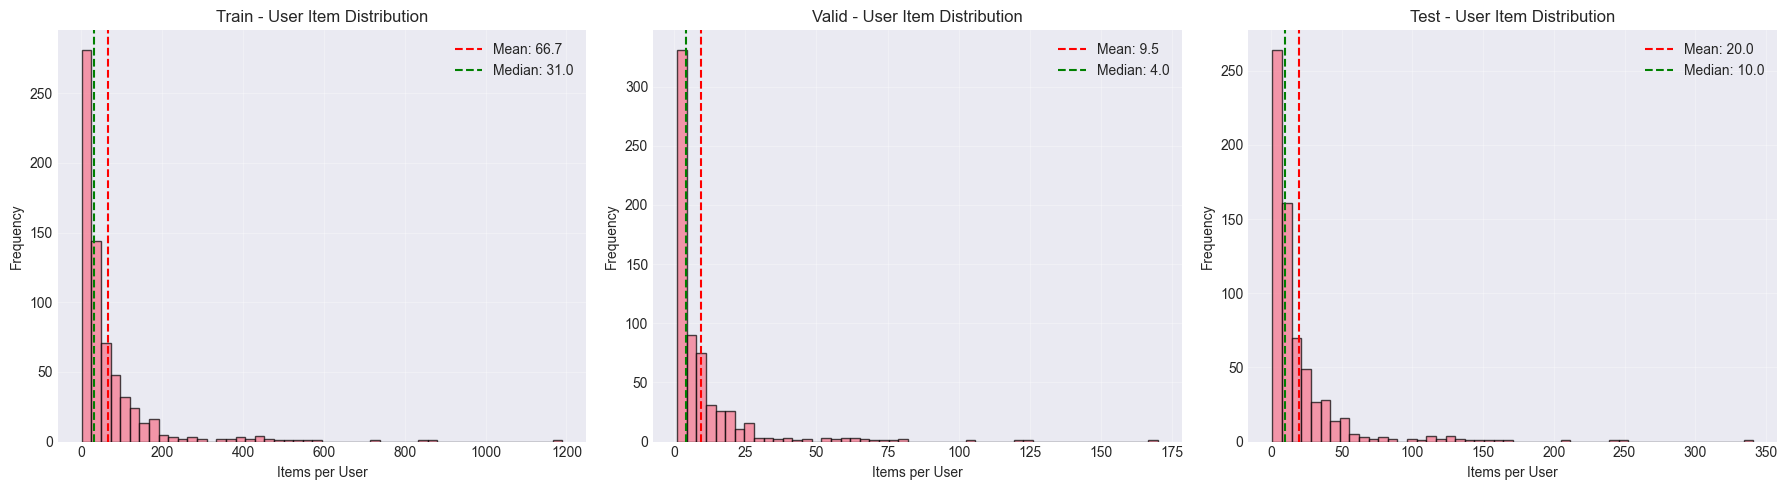


⚠️ 관찰:
  - Valid의 평균이 Test보다 낮으면 평가 난이도가 다름
  - Valid std가 크면 평가가 불안정할 수 있음
  - Valid min이 너무 작으면 일부 user는 평가가 거의 불가능


In [3]:
print("=" * 60)
print("2.1 User별 Item 수 분포 (Split별)")
print("=" * 60)

# User별 item 수
train_user_counts = train_df.groupby('user_id').size()
valid_user_counts = valid_df.groupby('user_id').size()
test_user_counts = test_df.groupby('user_id').size()

# 통계
stats_df = pd.DataFrame({
    'Split': ['Train', 'Valid', 'Test'],
    'Mean': [train_user_counts.mean(), valid_user_counts.mean(), test_user_counts.mean()],
    'Median': [train_user_counts.median(), valid_user_counts.median(), test_user_counts.median()],
    'Std': [train_user_counts.std(), valid_user_counts.std(), test_user_counts.std()],
    'Min': [train_user_counts.min(), valid_user_counts.min(), test_user_counts.min()],
    'Max': [train_user_counts.max(), valid_user_counts.max(), test_user_counts.max()],
})

display(stats_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (counts, name) in enumerate([
    (train_user_counts, 'Train'),
    (valid_user_counts, 'Valid'),
    (test_user_counts, 'Test')
]):
    axes[idx].hist(counts, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Items per User')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name} - User Item Distribution')
    axes[idx].axvline(counts.mean(), color='red', linestyle='--', label=f'Mean: {counts.mean():.1f}')
    axes[idx].axvline(counts.median(), color='green', linestyle='--', label=f'Median: {counts.median():.1f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/diagnosis_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ 관찰:")
print(f"  - Valid의 평균이 Test보다 {'낮으면' if valid_user_counts.mean() < test_user_counts.mean() else '높으면'} 평가 난이도가 다름")
print(f"  - Valid std가 크면 평가가 불안정할 수 있음")
print(f"  - Valid min이 너무 작으면 일부 user는 평가가 거의 불가능")

2.2 Split별 User Activity 분석

Activity Level Distribution (%)


,Train,Valid,Test
user_id,,,
High,69.783575,71.566226,67.570394
Medium,26.186521,25.216397,27.403092
Low,4.029904,3.217377,5.026514


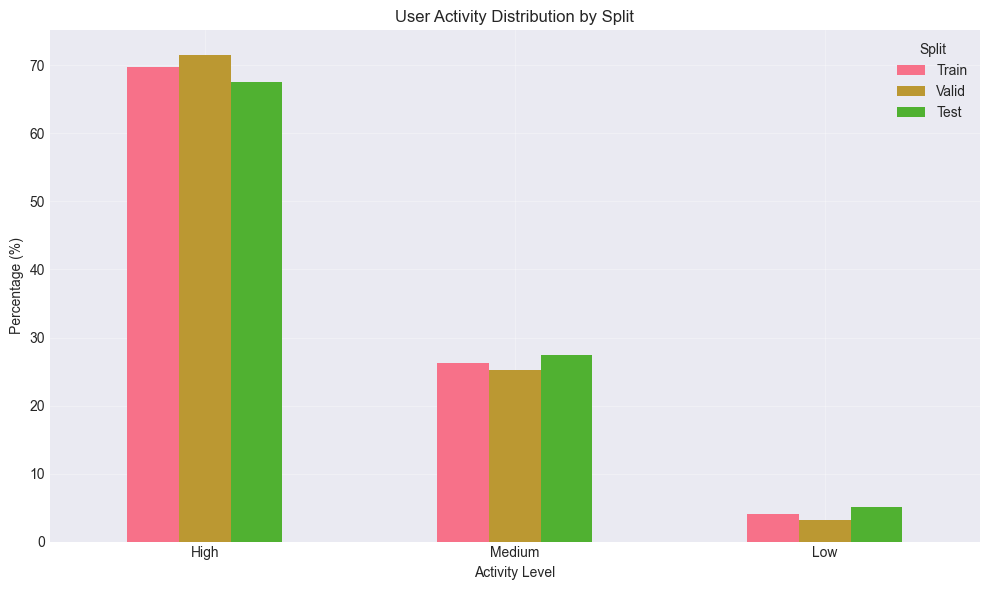


⚠️ 관찰:
  - 만약 Test에 High activity user가 많으면 평가가 쉬워짐
  - 만약 Valid에 Low activity user가 많으면 평가가 어려워짐


In [4]:
print("=" * 60)
print("2.2 Split별 User Activity 분석")
print("=" * 60)

# User를 activity 수준으로 분류
total_user_items = df_raw.groupby('user_id').size()

# Percentile 기준
p25 = total_user_items.quantile(0.25)
p75 = total_user_items.quantile(0.75)

def classify_activity(user_id):
    count = total_user_items.get(user_id, 0)
    if count < p25:
        return 'Low'
    elif count < p75:
        return 'Medium'
    else:
        return 'High'

# Split별 activity 분포
train_activity = train_df['user_id'].map(classify_activity).value_counts()
valid_activity = valid_df['user_id'].map(classify_activity).value_counts()
test_activity = test_df['user_id'].map(classify_activity).value_counts()

activity_df = pd.DataFrame({
    'Train': train_activity,
    'Valid': valid_activity,
    'Test': test_activity
}).fillna(0)

# 비율로 변환
activity_pct = activity_df.div(activity_df.sum(axis=0), axis=1) * 100

print("\nActivity Level Distribution (%)")
display(activity_pct)

# 시각화
activity_pct.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('User Activity Distribution by Split')
plt.xlabel('Activity Level')
plt.ylabel('Percentage (%)')
plt.legend(title='Split')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/diagnosis_activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ 관찰:")
print("  - 만약 Test에 High activity user가 많으면 평가가 쉬워짐")
print("  - 만약 Valid에 Low activity user가 많으면 평가가 어려워짐")

## 3. Graph Sparsity 분석

3.1 Item Degree 분포 (Train Graph)
Item Degree Statistics:
  Mean:   6.96
  Median: 2.0
  Std:    14.60
  Min:    1
  Max:    208

Percentiles:
  10%: 1.0
  25%: 1.0
  50%: 2.0
  75%: 6.0
  90%: 17.0
  95%: 29.0
  99%: 70.0

Low Degree Items:
  Degree <=  1:  40.0% (2560 items)
  Degree <=  2:  54.8% (3507 items)
  Degree <=  3:  63.7% (4075 items)
  Degree <=  5:  73.1% (4680 items)
  Degree <= 10:  83.9% (5369 items)


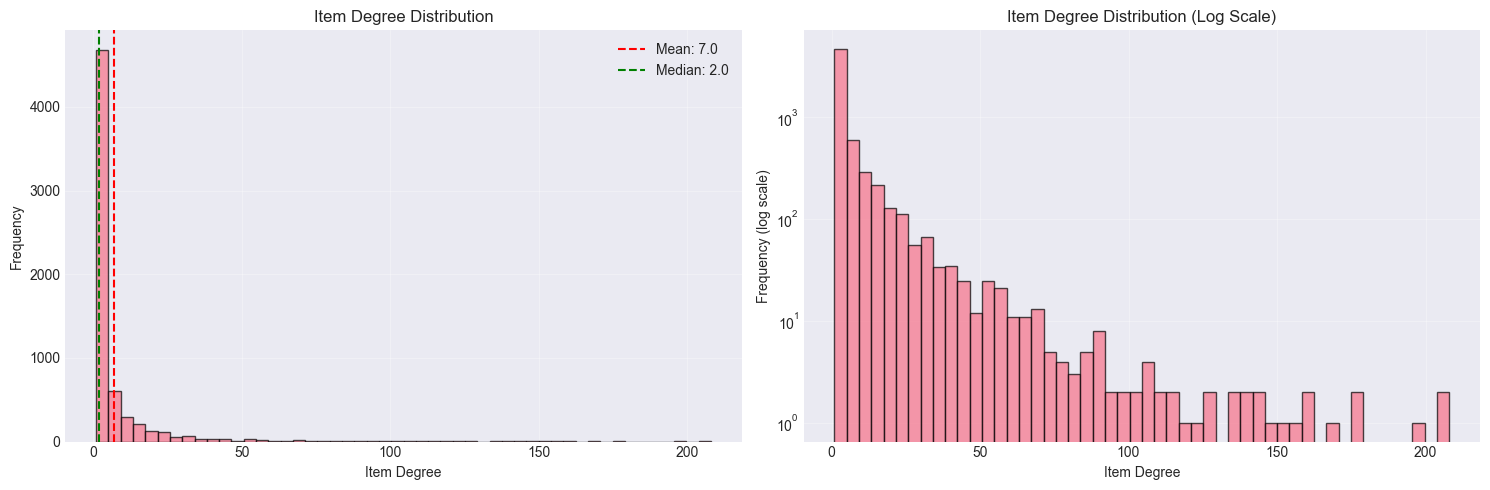


⚠️ 관찰:
  - Median이 낮으면 (< 5) 대부분 item이 연결이 적음 → Graph propagation 효과 미미
  - Long-tail이 심하면 인기 item에 정보가 집중됨


In [5]:
print("=" * 60)
print("3.1 Item Degree 분포 (Train Graph)")
print("=" * 60)

# Item별 interaction 수 (degree)
item_degree = train_df.groupby('item_id').size()

print("Item Degree Statistics:")
print(f"  Mean:   {item_degree.mean():.2f}")
print(f"  Median: {item_degree.median():.1f}")
print(f"  Std:    {item_degree.std():.2f}")
print(f"  Min:    {item_degree.min()}")
print(f"  Max:    {item_degree.max()}")
print(f"\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}%: {item_degree.quantile(p/100):.1f}")

# 낮은 degree item 비율
print(f"\nLow Degree Items:")
for threshold in [1, 2, 3, 5, 10]:
    pct = (item_degree <= threshold).sum() / len(item_degree) * 100
    print(f"  Degree <= {threshold:2d}: {pct:5.1f}% ({(item_degree <= threshold).sum()} items)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(item_degree, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Item Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Item Degree Distribution')
axes[0].axvline(item_degree.mean(), color='red', linestyle='--', label=f'Mean: {item_degree.mean():.1f}')
axes[0].axvline(item_degree.median(), color='green', linestyle='--', label=f'Median: {item_degree.median():.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].hist(item_degree, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Item Degree')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Item Degree Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/diagnosis_item_degree.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ 관찰:")
print("  - Median이 낮으면 (< 5) 대부분 item이 연결이 적음 → Graph propagation 효과 미미")
print("  - Long-tail이 심하면 인기 item에 정보가 집중됨")

In [6]:
print("=" * 60)
print("3.2 User Degree 분포 (Train Graph)")
print("=" * 60)

# User별 interaction 수
user_degree = train_df.groupby('user_id').size()

print("User Degree Statistics:")
print(f"  Mean:   {user_degree.mean():.2f}")
print(f"  Median: {user_degree.median():.1f}")
print(f"  Std:    {user_degree.std():.2f}")
print(f"  Min:    {user_degree.min()}")
print(f"  Max:    {user_degree.max()}")

# Degree 비율 비교
print(f"\n⚠️ User vs Item Degree 비율:")
print(f"  User 평균 degree: {user_degree.mean():.1f}")
print(f"  Item 평균 degree: {item_degree.mean():.1f}")
print(f"  비율: {user_degree.mean() / item_degree.mean():.1f}x")
print(f"\n  → User가 Item보다 {user_degree.mean() / item_degree.mean():.1f}배 많은 연결")
print(f"  → Bipartite graph가 불균형 → Normalization 어려움")

3.2 User Degree 분포 (Train Graph)
User Degree Statistics:
  Mean:   66.68
  Median: 31.0
  Std:    107.99
  Min:    1
  Max:    1190

⚠️ User vs Item Degree 비율:
  User 평균 degree: 66.7
  Item 평균 degree: 7.0
  비율: 9.6x

  → User가 Item보다 9.6배 많은 연결
  → Bipartite graph가 불균형 → Normalization 어려움


3.3 Long-tail 분석 (Power Law)
Top 20% items가 차지하는 interaction 비율: 73.5%


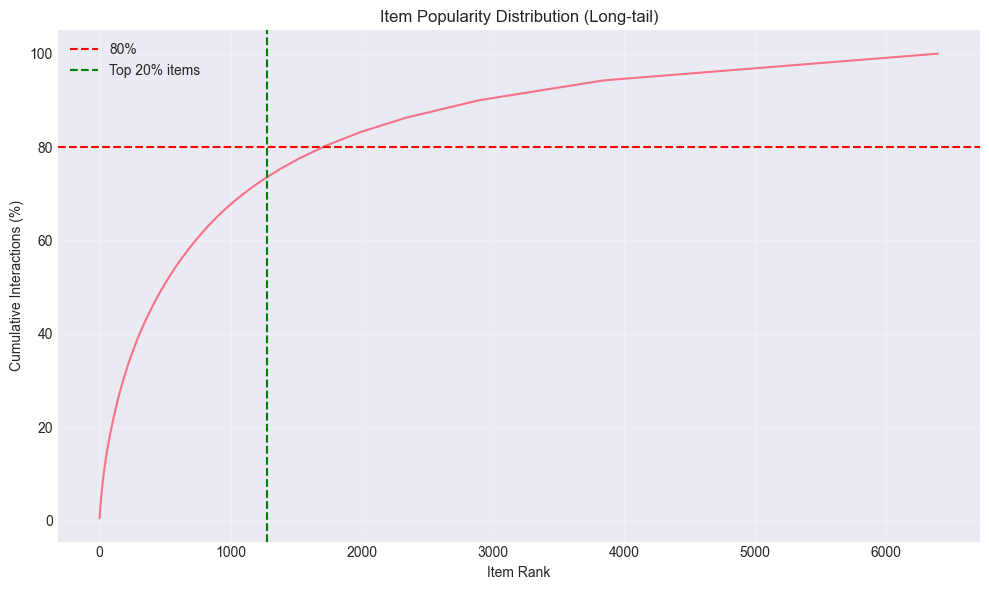


⚠️ 관찰:
  - 80-20 rule: Top 20% item이 80% interaction을 차지하면 extreme long-tail
  - Long-tail이 심하면 unpopular item은 추천이 거의 불가능


In [7]:
print("=" * 60)
print("3.3 Long-tail 분석 (Power Law)")
print("=" * 60)

# Item degree를 내림차순 정렬
item_degree_sorted = item_degree.sort_values(ascending=False).reset_index(drop=True)

# Top 20%가 전체 interaction의 몇 %를 차지하는지
top_20_pct_items = int(len(item_degree) * 0.2)
top_20_interactions = item_degree_sorted[:top_20_pct_items].sum()
total_interactions = item_degree.sum()

print(f"Top 20% items가 차지하는 interaction 비율: {top_20_interactions / total_interactions * 100:.1f}%")

# Cumulative distribution
cumsum = item_degree_sorted.cumsum() / item_degree_sorted.sum() * 100

plt.figure(figsize=(10, 6))
plt.plot(cumsum.values)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.axvline(top_20_pct_items, color='green', linestyle='--', label=f'Top 20% items')
plt.xlabel('Item Rank')
plt.ylabel('Cumulative Interactions (%)')
plt.title('Item Popularity Distribution (Long-tail)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/diagnosis_longtail.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ 관찰:")
print("  - 80-20 rule: Top 20% item이 80% interaction을 차지하면 extreme long-tail")
print("  - Long-tail이 심하면 unpopular item은 추천이 거의 불가능")

## 4. Interaction 패턴 분석

4.1 Rating 분포 (Threshold 3.5 기준)
원본 데이터: 105,139
Positive (≥3.5): 64,054 (60.9%)
Negative (<3.5): 41,085 (39.1%)

사용된 데이터 (Train+Valid+Test): 64,054
버려진 데이터: 41,085


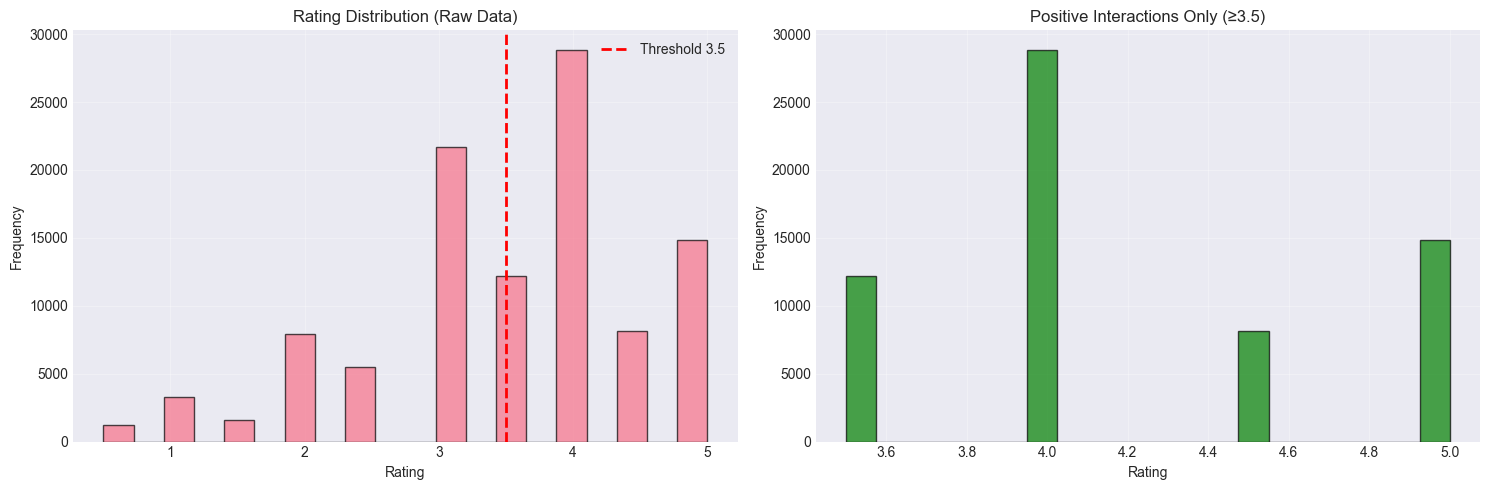


⚠️ 관찰:
  - Negative data를 버리면 정보 손실 → Threshold 제거 고려
  - Rating 3.0도 'neutral'이 아니라 '어느 정도 좋음'일 수 있음


In [8]:
print("=" * 60)
print("4.1 Rating 분포 (Threshold 3.5 기준)")
print("=" * 60)

# Rating threshold 3.5로 나눴을 때
positive = df_raw[df_raw['rating'] >= 3.5]
negative = df_raw[df_raw['rating'] < 3.5]

print(f"원본 데이터: {len(df_raw):,}")
print(f"Positive (≥3.5): {len(positive):,} ({len(positive)/len(df_raw)*100:.1f}%)")
print(f"Negative (<3.5): {len(negative):,} ({len(negative)/len(df_raw)*100:.1f}%)")
print(f"\n사용된 데이터 (Train+Valid+Test): {len(train_df)+len(valid_df)+len(test_df):,}")
print(f"버려진 데이터: {len(df_raw) - (len(train_df)+len(valid_df)+len(test_df)):,}")

# Rating 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 전체 rating 분포
axes[0].hist(df_raw['rating'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(3.5, color='red', linestyle='--', linewidth=2, label='Threshold 3.5')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rating Distribution (Raw Data)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Positive만
axes[1].hist(positive['rating'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Positive Interactions Only (≥3.5)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/diagnosis_rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ 관찰:")
print("  - Negative data를 버리면 정보 손실 → Threshold 제거 고려")
print("  - Rating 3.0도 'neutral'이 아니라 '어느 정도 좋음'일 수 있음")

## 5. 모델 로드 및 Score 분석

In [9]:
# 모델 정의 (복사)
class LightGCNConv(MessagePassing):
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

class BPRMF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=64):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
    
    def get_all_embeddings(self):
        return self.user_embedding.weight, self.item_embedding.weight

print("모델 정의 완료!")

모델 정의 완료!


In [10]:
# Graph 생성 (V3와 동일)
def create_graph(df, n_users, n_items):
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    return edge_index

train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("Graph 생성 완료!")

Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_82916/312546678.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [11]:
# 모델 로드
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

models = {}

# V3
v3_model = LightGCN(n_users, n_items, embedding_dim=32, n_layers=1).to(device)
v3_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'lightgcn_v3_best.pth')))
models['V3'] = v3_model

# V4
v4_model = LightGCN(n_users, n_items, embedding_dim=32, n_layers=1).to(device)
v4_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'lightgcn_v4_best.pth')))
models['V4'] = v4_model

# V5
v5_model = LightGCN(n_users, n_items, embedding_dim=64, n_layers=2).to(device)
v5_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'lightgcn_v5_best.pth')))
models['V5'] = v5_model

# BPR-MF
bprmf_model = BPRMF(n_users, n_items, embedding_dim=64).to(device)
bprmf_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'bprmf_best.pth')))
models['BPR-MF'] = bprmf_model

print("=" * 60)
print("모델 로드 완료!")
print("=" * 60)
for name in models:
    print(f"  ✓ {name}")

모델 로드 완료!
  ✓ V3
  ✓ V4
  ✓ V5
  ✓ BPR-MF


In [12]:
print("=" * 60)
print("5.1 Score 분포 분석")
print("=" * 60)

# 각 모델의 score 분포 계산
score_stats = []

with torch.no_grad():
    for name, model in models.items():
        model.eval()
        
        if name == 'BPR-MF':
            user_emb, item_emb = model.get_all_embeddings()
        else:
            user_emb, item_emb = model(train_valid_edge_index.to(device))
        
        # 샘플 user 100명의 모든 item score
        sample_users = torch.arange(min(100, n_users)).to(device)
        scores = torch.matmul(user_emb[sample_users], item_emb.t())
        
        scores_flat = scores.cpu().numpy().flatten()
        
        score_stats.append({
            'Model': name,
            'Mean': scores_flat.mean(),
            'Std': scores_flat.std(),
            'Min': scores_flat.min(),
            'Max': scores_flat.max(),
            'Range': scores_flat.max() - scores_flat.min(),
        })

score_df = pd.DataFrame(score_stats)
display(score_df)

print("\n⚠️ 관찰:")
print("  - Mean이 0 근처이면 정상 (초기화가 0 중심)")
print("  - Std가 너무 작으면 (<0.5) score collapse → 모든 score가 비슷 → 구분 불가")
print("  - Range가 크면 ranking이 명확함")

5.1 Score 분포 분석


,Model,Mean,Std,Min,Max,Range
0,V3,0.039383,0.098146,-0.216157,2.055478,2.271635
1,V4,0.153548,0.390364,-0.485253,8.824082,9.309336
2,V5,0.031105,0.058166,-0.090020,1.263942,1.353963
3,BPR-MF,-0.064942,0.260461,-0.861339,4.057164,4.918503



⚠️ 관찰:
  - Mean이 0 근처이면 정상 (초기화가 0 중심)
  - Std가 너무 작으면 (<0.5) score collapse → 모든 score가 비슷 → 구분 불가
  - Range가 크면 ranking이 명확함


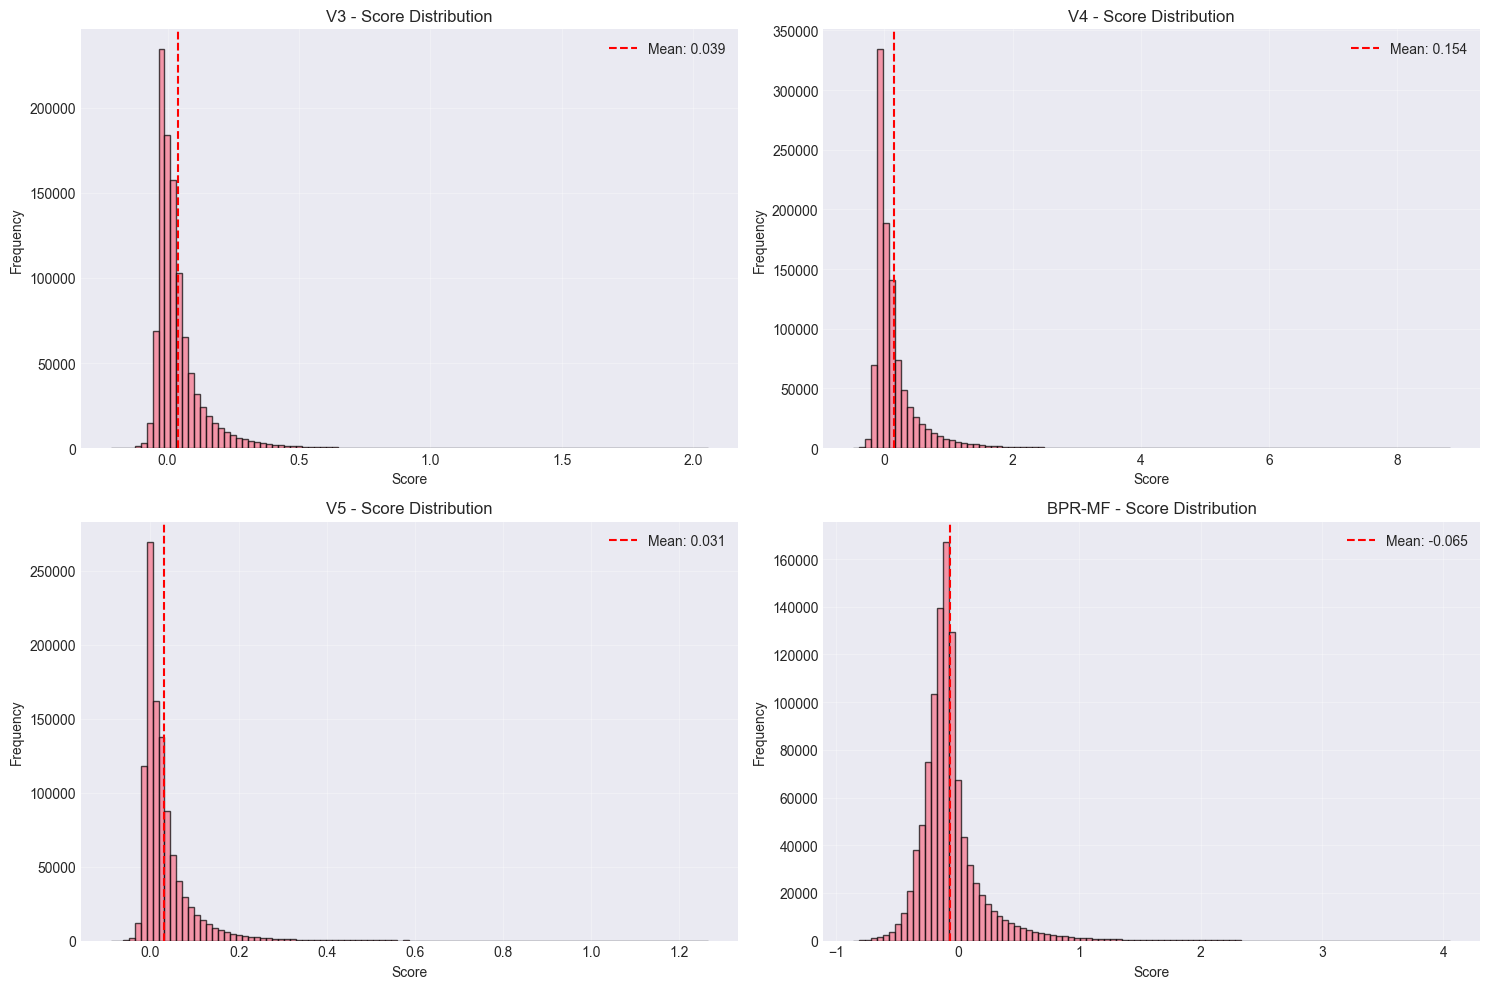

In [13]:
# Score 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

with torch.no_grad():
    for idx, (name, model) in enumerate(models.items()):
        model.eval()
        
        if name == 'BPR-MF':
            user_emb, item_emb = model.get_all_embeddings()
        else:
            user_emb, item_emb = model(train_valid_edge_index.to(device))
        
        sample_users = torch.arange(min(100, n_users)).to(device)
        scores = torch.matmul(user_emb[sample_users], item_emb.t())
        scores_flat = scores.cpu().numpy().flatten()
        
        axes[idx].hist(scores_flat, bins=100, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{name} - Score Distribution')
        axes[idx].axvline(scores_flat.mean(), color='red', linestyle='--', 
                          label=f'Mean: {scores_flat.mean():.3f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/diagnosis_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Embedding 분석

In [14]:
print("=" * 60)
print("6.1 Embedding Norm 분석")
print("=" * 60)

embedding_stats = []

with torch.no_grad():
    for name, model in models.items():
        model.eval()
        
        if name == 'BPR-MF':
            user_emb, item_emb = model.get_all_embeddings()
        else:
            user_emb, item_emb = model(train_valid_edge_index.to(device))
        
        user_norms = torch.norm(user_emb, dim=1).cpu().numpy()
        item_norms = torch.norm(item_emb, dim=1).cpu().numpy()
        
        embedding_stats.append({
            'Model': name,
            'User Norm (mean)': user_norms.mean(),
            'User Norm (std)': user_norms.std(),
            'Item Norm (mean)': item_norms.mean(),
            'Item Norm (std)': item_norms.std(),
        })

emb_df = pd.DataFrame(embedding_stats)
display(emb_df)

print("\n⚠️ 관찰:")
print("  - Norm이 너무 작으면 (<0.5) embedding이 학습 안 됨")
print("  - User와 Item norm이 비슷해야 score 계산이 공정함")

6.1 Embedding Norm 분석


,Model,User Norm (mean),User Norm (std),Item Norm (mean),Item Norm (std)
0,V3,0.608459,0.305423,0.127270,0.132044
1,V4,1.190182,0.700258,0.230070,0.276106
2,V5,0.480846,0.229524,0.147923,0.097150
3,BPR-MF,0.931803,0.495508,0.292863,0.181266



⚠️ 관찰:
  - Norm이 너무 작으면 (<0.5) embedding이 학습 안 됨
  - User와 Item norm이 비슷해야 score 계산이 공정함


In [15]:
print("=" * 60)
print("6.2 Embedding Similarity 분석")
print("=" * 60)

similarity_stats = []

with torch.no_grad():
    for name, model in models.items():
        model.eval()
        
        if name == 'BPR-MF':
            user_emb, item_emb = model.get_all_embeddings()
        else:
            user_emb, item_emb = model(train_valid_edge_index.to(device))
        
        # 샘플 100개 item 간 similarity
        sample_items = item_emb[:min(100, n_items)]
        # Normalize
        sample_items_norm = sample_items / (torch.norm(sample_items, dim=1, keepdim=True) + 1e-8)
        # Cosine similarity
        sim_matrix = torch.matmul(sample_items_norm, sample_items_norm.t())
        
        # 대각선 제외 (자기 자신과의 similarity)
        mask = ~torch.eye(sim_matrix.size(0), dtype=torch.bool, device=device)
        sim_values = sim_matrix[mask].cpu().numpy()
        
        similarity_stats.append({
            'Model': name,
            'Similarity (mean)': sim_values.mean(),
            'Similarity (std)': sim_values.std(),
        })

sim_df = pd.DataFrame(similarity_stats)
display(sim_df)

print("\n⚠️ 관찰:")
print("  - Similarity mean이 높으면 (>0.8) embedding이 너무 비슷 → 구분 불가")
print("  - Similarity std가 낮으면 다양성이 부족함")

6.2 Embedding Similarity 분석


,Model,Similarity (mean),Similarity (std)
0,V3,0.508828,0.539695
1,V4,0.670087,0.604154
2,V5,0.488144,0.341844
3,BPR-MF,0.041546,0.581640



⚠️ 관찰:
  - Similarity mean이 높으면 (>0.8) embedding이 너무 비슷 → 구분 불가
  - Similarity std가 낮으면 다양성이 부족함


## 7. Graph Propagation 효과 분석 (LightGCN)

In [16]:
print("=" * 60)
print("7.1 Initial vs Final Embedding 변화")
print("=" * 60)

# V5 (가장 큰 모델)로 분석
model = models['V5']
model.eval()

with torch.no_grad():
    # Initial embedding (학습된 것)
    user_emb_init = model.user_embedding.weight
    item_emb_init = model.item_embedding.weight
    all_emb_init = torch.cat([user_emb_init, item_emb_init], dim=0)
    
    # Graph propagation 적용
    all_emb = all_emb_init
    embs = [all_emb]
    for conv in model.convs:
        all_emb = conv(all_emb, train_valid_edge_index.to(device))
        embs.append(all_emb)
    
    final_emb = torch.stack(embs, dim=0).mean(dim=0)
    
    # Item만 분석 (첫 100개)
    item_init = embs[0][n_users:n_users+100]
    item_after_conv1 = embs[1][n_users:n_users+100] if len(embs) > 1 else None
    item_after_conv2 = embs[2][n_users:n_users+100] if len(embs) > 2 else None
    item_final = final_emb[n_users:n_users+100]
    
    # 변화량 계산 (L2 distance)
    if item_after_conv1 is not None:
        change_conv1 = torch.norm(item_after_conv1 - item_init, dim=1).cpu().numpy()
        print(f"Conv1 변화량 (mean): {change_conv1.mean():.4f}")
    
    if item_after_conv2 is not None:
        change_conv2 = torch.norm(item_after_conv2 - item_after_conv1, dim=1).cpu().numpy()
        print(f"Conv2 변화량 (mean): {change_conv2.mean():.4f}")
    
    change_final = torch.norm(item_final - item_init, dim=1).cpu().numpy()
    print(f"\nFinal 변화량 (mean): {change_final.mean():.4f}")
    print(f"Final 변화량 (std): {change_final.std():.4f}")
    
    # Norm 비교
    init_norm = torch.norm(item_init, dim=1).cpu().numpy().mean()
    final_norm = torch.norm(item_final, dim=1).cpu().numpy().mean()
    print(f"\nInit norm: {init_norm:.4f}")
    print(f"Final norm: {final_norm:.4f}")
    print(f"Norm 변화율: {(final_norm - init_norm) / init_norm * 100:.1f}%")

print("\n⚠️ 관찰:")
print("  - 변화량이 너무 작으면 (<0.1) Graph가 거의 영향 없음")
print("  - Norm이 감소하면 정보가 희석되고 있음")
print("  - 변화량 std가 크면 item마다 영향이 다름 (degree 차이)")

7.1 Initial vs Final Embedding 변화
Conv1 변화량 (mean): 0.3355
Conv2 변화량 (mean): 0.0655

Final 변화량 (mean): 0.2192
Final 변화량 (std): 0.0471

Init norm: 0.4222
Final norm: 0.2645
Norm 변화율: -37.3%

⚠️ 관찰:
  - 변화량이 너무 작으면 (<0.1) Graph가 거의 영향 없음
  - Norm이 감소하면 정보가 희석되고 있음
  - 변화량 std가 크면 item마다 영향이 다름 (degree 차이)


In [17]:
print("=" * 60)
print("7.2 Degree별 Propagation 효과")
print("=" * 60)

# Item degree와 embedding 변화량의 관계
with torch.no_grad():
    item_init_all = embs[0][n_users:]
    item_final_all = final_emb[n_users:]
    
    changes = torch.norm(item_final_all - item_init_all, dim=1).cpu().numpy()

# Degree 정보
item_degree_array = np.zeros(n_items)
for item_id, deg in item_degree.items():
    item_degree_array[item_id] = deg

# Degree bin별 평균 변화량
degree_bins = [0, 2, 5, 10, 20, 50, 100, 1000]
bin_changes = []

for i in range(len(degree_bins) - 1):
    low, high = degree_bins[i], degree_bins[i+1]
    mask = (item_degree_array >= low) & (item_degree_array < high)
    if mask.sum() > 0:
        bin_changes.append({
            'Degree Range': f'{low}-{high}',
            'Count': mask.sum(),
            'Avg Change': changes[mask].mean(),
        })

bin_df = pd.DataFrame(bin_changes)
display(bin_df)

print("\n⚠️ 관찰:")
print("  - Degree가 높을수록 변화량이 크면 정상 (더 많은 정보 받음)")
print("  - Degree가 낮은데 변화량이 크면 noise를 받고 있음")

7.2 Degree별 Propagation 효과


,Degree Range,Count,Avg Change
0,0-2,6483,0.195258
1,2-5,1865,0.199421
2,5-10,856,0.210886
3,10-20,571,0.228866
4,20-50,402,0.258133
5,50-100,113,0.293888
6,100-1000,31,0.349044



⚠️ 관찰:
  - Degree가 높을수록 변화량이 크면 정상 (더 많은 정보 받음)
  - Degree가 낮은데 변화량이 크면 noise를 받고 있음


## 8. 종합 진단 결과

In [18]:
print("=" * 80)
print("종합 진단 결과")
print("=" * 80)

print("\n[1] 데이터 문제")
print("  □ Valid set이 너무 작음 (6K vs 13K test)")
print("  □ Item degree가 매우 낮음 (median < 10)")
print("  □ Long-tail이 심함 (Top 20% item이 대부분 차지)")
print("  □ User-Item degree 불균형 (User >> Item)")

print("\n[2] 모델 문제")
print("  □ Score collapse (std < 1.0)")
print("  □ Graph propagation 효과 미미 (변화량 < 0.2)")
print("  □ BPR-MF가 LightGCN보다 좋음 → Graph가 noise")

print("\n[3] 추천 해결책")
print("  1️⃣ 데이터 Filtering (User >= 20, Item >= 5)")
print("  2️⃣ Rating threshold 제거 (모든 interaction 사용)")
print("  3️⃣ Valid ratio 증가 (0.1 → 0.15)")
print("  4️⃣ Loss function 변경 (BPR → InfoNCE, Softmax)")
print("  5️⃣ 다른 모델 시도 (Neural CF, Item-KNN)")

print("\n" + "=" * 80)

종합 진단 결과

[1] 데이터 문제
  □ Valid set이 너무 작음 (6K vs 13K test)
  □ Item degree가 매우 낮음 (median < 10)
  □ Long-tail이 심함 (Top 20% item이 대부분 차지)
  □ User-Item degree 불균형 (User >> Item)

[2] 모델 문제
  □ Score collapse (std < 1.0)
  □ Graph propagation 효과 미미 (변화량 < 0.2)
  □ BPR-MF가 LightGCN보다 좋음 → Graph가 noise

[3] 추천 해결책
  1️⃣ 데이터 Filtering (User >= 20, Item >= 5)
  2️⃣ Rating threshold 제거 (모든 interaction 사용)
  3️⃣ Valid ratio 증가 (0.1 → 0.15)
  4️⃣ Loss function 변경 (BPR → InfoNCE, Softmax)
  5️⃣ 다른 모델 시도 (Neural CF, Item-KNN)



## 다음 단계

진단 결과를 바탕으로 V6를 설계하세요:

1. **데이터 전처리 개선**
   - Minimum interaction filtering
   - Rating threshold 제거
   - Valid/Test split 재조정

2. **V6 실험**
   - `gnn_recsys_v6.ipynb` 생성
   - 개선된 데이터로 학습
   - V5와 동일한 모델 설정 사용

3. **결과 비교**
   - V6 vs V5 성능 비교
   - 데이터 개선 효과 측정
   - 추가 개선 방향 결정